# Chapter 3 Classification

## MNIST

** In this chapter, we will be using the MNIST dataset. **

Sklearn provides many helper functions to download popular datasets.

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

Datasets loaded by Skleran have a similar dictionary structure:
* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature.
* A target key containing an array with the labels.

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

** Take a peek at one digit from the dataset.**

* grap an instance's feature vector, reshape it to 28*28 array, and display it using Matplotlib's imshow() function:

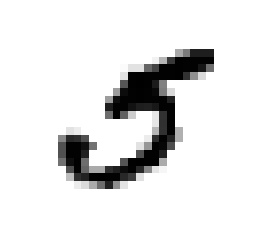

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = 'nearest')
plt.axis('off')
plt.show()

In [6]:
#let' see the label
y[36000]

5.0

We should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set(the first 60,000 images) and a test set(the last 10,000 images):

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#shuffle the training set; This will guarantee that all cross-validation folds will be similar

import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

* Simplify the problem and only try to identify one digit-number 5. This is  a binary classifier


In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

* Now let's pick a classifier and train it. Using sklearn's SGDClassifier class.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
#use it to detect images of the number 5:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measures

* Evaluating a classifier is ofen significantly trickier than evaluating a regressor.

### Measuring Accuracy using Cross-Validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96965
0.9588
0.9619


In [12]:
#Use the cross_val_score() function to evaluate our SGDClassifier model using K-fold cv, with three
#folds.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.96965,  0.9588 ,  0.9619 ])

* Look at a very dumb classifier that just classifies every single image in the 'not-5' class

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

#check the accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.90665,  0.9109 ,  0.9114 ])

** The above example shows that accuracy is generally not the preferred performance measure for classifiers, especially when we are dealing with skewed datasets.**

### Confusion Matrix

* The general idea is to count the number of times instances of class A are classified as class B.

* cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

array([[53860,   719],
       [ 1474,  3947]])

** The precision of the classifier **

Equation 3-1. Precison
* precision = TP/(TP+FP)

Equation 3-2. Recll
* recall = TP/(TP+FN)

### Precision and Recall

sklearn provides several functions to compute classifier metrics

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.84590655808
0.728094447519


** We can combine precision and recall into a single metric called the F1 score **

Equation 3-3. F1 score
* F1=TP/(TP+(FN+FP)/2)

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78259145434717969

### Precision/Recall Tradeoff

Increasing precision reduces recall, and vice versa.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 84518.31164816])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [19]:
y_some_digit_pred

array([ True], dtype=bool)

In [20]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In order to decide which threshold to use, we will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that we want it to return dicision scores instead of predictinos.

then we can compute precision and recall for all possibel thresholds using the precision_recall_curve() function:

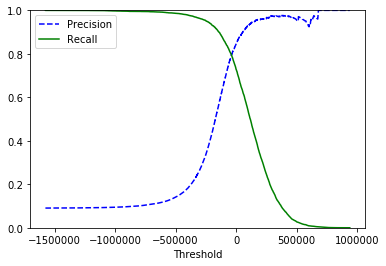

In [22]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

As we can see, it is fairly easy to create a classifier with virtually any precision we want: just set a high enough threshold, and we're done. 

A high-precision classifier is not very useful if its recall is too low

In [23]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.91157420444945081

In [24]:
recall_score(y_train_5, y_train_pred_90)

0.59712230215827333

### The ROC Curve (receiver operating characteristic)

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐ ting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called speci city. Hence the ROC curve plots sensitivity (recall) versus 1 – speci city.

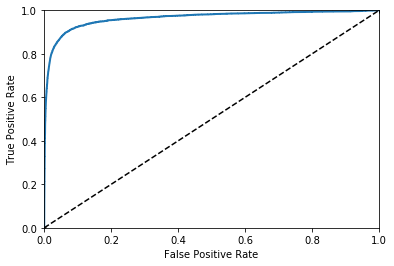

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--1')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

* One way to compare classifiers is to measure the area under the curve(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96428733069001471

* Let's train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.

* the RandomForestClassifier class does not have a decision_function(). Instead it has a predict_proba() method.

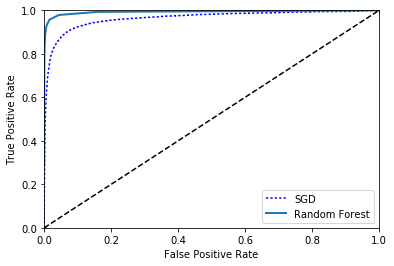

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method='predict_proba')

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312476921878434

## Multiclass Classification

* Random Forest classifiers or naive Bayes classifiers are caple of handling multiple classes directly.
* SVM classifiers or Linear classifiers are strictly binary classifiers.
* We can perform multiclass classification using multiple binary classifiers.(one versus all)

** Sklearn dectects when we try to use binary classification algorithm for a multiclass classification task, and it automatically runs OvA. **



In [30]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [31]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-232764.72017692, -560602.52437853, -294834.17005906,
        -249713.77232777, -333181.96069738,   84518.31164816,
        -722853.52657793, -155126.70745039, -603327.46820628,
        -798124.44758421]])

* If we want to force Sklearn to use OvO or OvA, we can use the OneVsOneClassifier or OneVsRestClassifier classes

In [32]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [33]:
len(ovo_clf.estimators_)

45

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [35]:
forest_clf.predict_proba([some_digit])

array([[ 0.2,  0. ,  0. ,  0.1,  0. ,  0.7,  0. ,  0. ,  0. ,  0. ]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.87102579,  0.86464323,  0.8740311 ])

In [37]:
#simply scaling the inputs will increases accuracy above 90%

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.90776845,  0.91089554,  0.90903636])

### Error Analysis

** We assume that we have found a promising model (using GridSearchCV) and we want to find ways to improve it. One way to do this is to analyze the types of errors it makes. **

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5713,    2,   23,   12,   11,   55,   53,    9,   40,    5],
       [   2, 6477,   44,   29,    6,   39,    6,   11,  118,   10],
       [  55,   38, 5327,  107,   80,   25,   82,   63,  167,   14],
       [  42,   40,  136, 5361,    2,  221,   37,   63,  144,   85],
       [  18,   26,   38,   10, 5369,    9,   56,   28,   81,  207],
       [  66,   40,   35,  194,   74, 4606,  114,   29,  175,   88],
       [  24,   23,   49,    2,   41,   93, 5630,   10,   46,    0],
       [  21,   19,   72,   20,   60,   13,    7, 5830,   16,  207],
       [  45,  148,   75,  172,   17,  166,   57,   30, 5010,  131],
       [  43,   30,   26,   87,  179,   34,    2,  223,   83, 5242]])

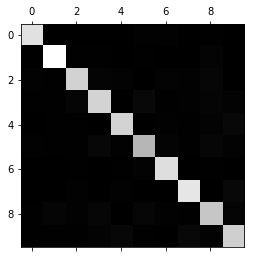

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

Let's focuns the plot on the errors:
* we need to divide each value in the confusion matrix by the number of images in the corresponding class.

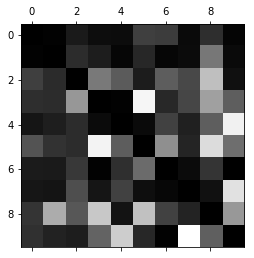

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* The columns for classes 8 and 9 are quite bright, which tells that many images get misclassified as 8s or 9s.

* The errors are not perfectly symmetrical; for example, there are more 5s misclassified as 8s than the reverse

* Analyzing the confusion matrix can give us insights on ways to improve our classifier.

* We could try to gather more training data for 8s or 9s, or engineer new features.

* Analyzing individual errors can also be a good way to gain insights, but it is more difficult and time-consuming.

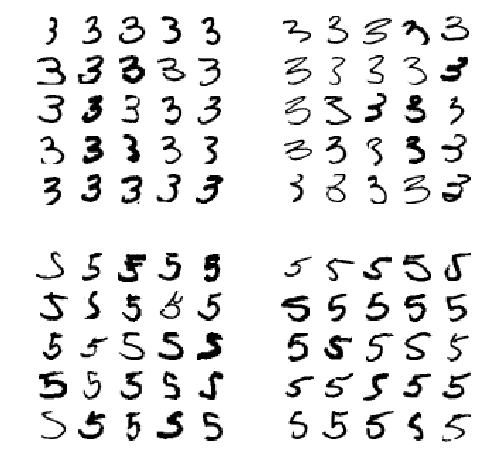

In [52]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

** A classification system that ouputs multiple binary labels**

In [38]:
from sklearn.neighbors import KNeighborsClassifier

#y_train_large = (y_train >= 7 )
#y_train_odd = (y_train % 2 == 1)
#y_multilabel = np.c_[y_train_large, y_train_odd]

#nn_clf = KNeighborsClassifier()
#knn_clf.fit(X_train, y_multilabel)
#knn_clf.predict([some_digit])

In [ ]:
#The code computes the average F1 score across all labels

#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred, average='macro')

## Multioutput Classification

** It is simply a generalization of multilabel classification where each label can be multicalss.**



## Exercises

1. Build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.



In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_neighbors': [3,6,9,12,15], 'weights':['uniform', 'distance']}]

knn_clf_2 = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf_2, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

KeyboardInterrupt: 